In [1]:
# === BLOCCO 1 - IMPORT LIBRERIE ===
import os
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import time
import seaborn as sns

# ML utils
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Classificatori
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron

# Deep learning
import tensorflow as tf
from tensorflow import keras


In [2]:
# ===============================================
# === BLOCCO 2 - LETTURA IMMAGINI E LABEL ===
# ===============================================

base_dir = Path('/Users/matteobraglia/Desktop/PROGETTO DATA/IndustryBiscuit/Images')
labels_csv = pd.read_csv('/Users/matteobraglia/Desktop/PROGETTO DATA/IndustryBiscuit/Annotations.csv')

file_to_class = dict(zip(labels_csv['file'], labels_csv['classCode']))

images, labels = [], []

for img_file in base_dir.glob("*.jpg"):
    try:
        img = Image.open(img_file).convert("RGB")
        images.append(np.array(img))
        labels.append(file_to_class[img_file.name])
    except Exception as e:
        print("Errore su", img_file, ":", e)

X = np.stack(images)
y = np.array(labels, dtype=np.int64)

class_mapping = dict(zip(labels_csv['classCode'], labels_csv['classDescription']))
num_classes = len(class_mapping)

print("Shape immagini:", X.shape)
print("Shape labels:", y.shape)
print("Classi:", class_mapping)



Shape immagini: (4900, 256, 256, 3)
Shape labels: (4900,)
Classi: {1: 'Defect_Shape', 2: 'Defect_Object', 3: 'Defect_Color', 0: 'Defect_No'}


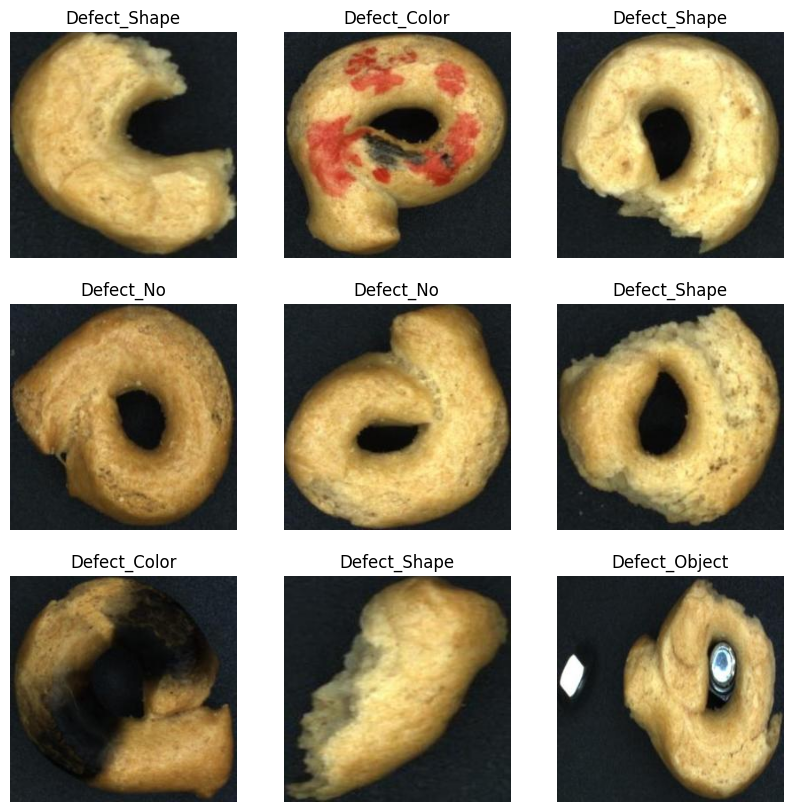

In [3]:
# ===============================================
# === BLOCCO 3 - VISUALIZZAZIONE PRIME IMMAGINI ===
# ===============================================

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X[i])
    plt.title(class_mapping[y[i]])
    plt.axis("off")
plt.show()


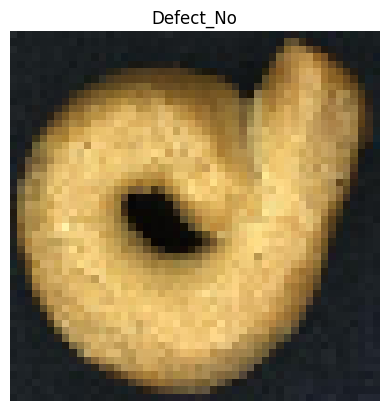

In [ ]:
# ===============================================
# === BLOCCO 4 - RIDIMENSIONAMENTO A 50x50 ===
# ===============================================

def resize_to_50(img):
    h, w = img.shape[:2]
    y_idx = np.linspace(0, h-1, 50).round().astype(int)
    x_idx = np.linspace(0, w-1, 50).round().astype(int)
    return img[y_idx][:, x_idx]

X50 = np.stack([resize_to_50(im) for im in X])
X50 = X50.astype("float32") / 255

# Visualizza un esempio ridimensionato
id = 175
plt.imshow(X50[id])
plt.title(class_mapping[y[id]])
plt.axis('off')
plt.show()



In [5]:
# ===============================================
# === BLOCCO 5 - TRAIN/TEST SPLIT ===
# ===============================================

x_train, x_test, y_train, y_test = train_test_split(
    X50, y, test_size=0.2, random_state=42, stratify=y
)

print('Train shape:', x_train.shape, 'Test shape:', x_test.shape)


Train shape: (3920, 50, 50, 3) Test shape: (980, 50, 50, 3)


In [18]:
# ===============================================
# === BLOCCO 6 - PCA + ML CLASSICI ===
# ===============================================

def fit_pca_features(X_train, n_components=100):
    N = X_train.shape[0]
    gray = X_train.mean(axis=3).reshape(N, -1)
    scaler = StandardScaler().fit(gray)
    gray_s = scaler.transform(gray)
    pca = PCA(n_components=n_components, random_state=42).fit(gray_s)
    X_pca = pca.transform(gray_s)
    return X_pca, scaler, pca

def transform_pca_features(X, scaler, pca):
    N = X.shape[0]
    gray = X.mean(axis=3).reshape(N, -1)
    gray_s = scaler.transform(gray)
    return pca.transform(gray_s)

X_train_feat, scaler, pca = fit_pca_features(x_train, n_components=100)
X_test_feat = transform_pca_features(x_test, scaler, pca)

print("Train features:", X_train_feat.shape)
print("Test features:", X_test_feat.shape)


# Helper valutazione
results = []

def evaluate_and_save(name, model, X_test_feat, y_test, y_pred, best_params=None, fit_time=None):
    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    macro_prec = precision_score(y_test, y_pred, average='macro')
    macro_rec = recall_score(y_test, y_pred, average='macro')

    print(f"\n===== {name} =====")
    print("Accuracy:", acc)
    print("F1-macro:", macro_f1)
    print("Precision-macro:", macro_prec)
    print("Recall-macro:", macro_rec)
    print("Best params:", best_params)

    results.append({
        "model": name,
        "accuracy": acc,
        "macro_f1": macro_f1,
        "macro_precision": macro_prec,
        "macro_recall": macro_rec,
        "best_params": best_params,
        "fit_time_sec": fit_time
    })

def plot_cm(model_name, y_true, y_pred, class_mapping):
    labels = [class_mapping[i] for i in range(len(class_mapping))]
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Train features: (3920, 100)
Test features: (980, 100)



===== KNN =====
Accuracy: 0.7683673469387755
F1-macro: 0.6738498931780865
Precision-macro: 0.8192268046959121
Recall-macro: 0.6455267273279643
Best params: {'metric': 'euclidean', 'n_neighbors': 3}


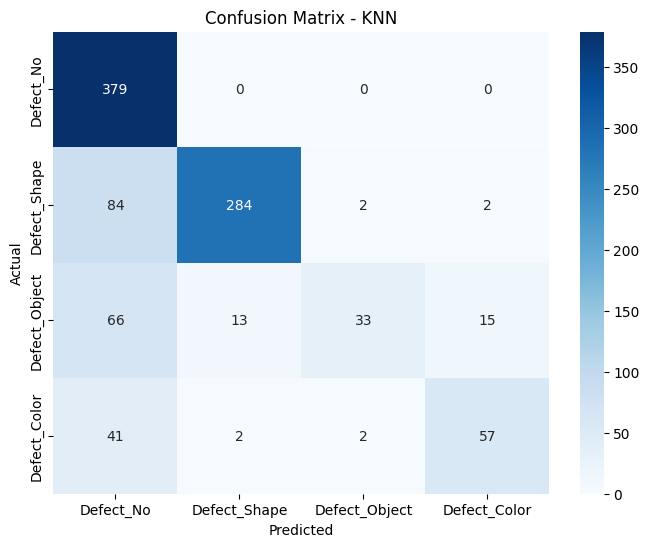

In [19]:
# ===== GridSearch + Modelli Classici =====
# KNN
param_grid = {"n_neighbors": [3,5,7], "metric": ["euclidean", "manhattan"]}
gs = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
t0 = time.time()
gs.fit(X_train_feat, y_train)
t1 = time.time()
y_pred = gs.best_estimator_.predict(X_test_feat)
evaluate_and_save("KNN", gs.best_estimator_, X_test_feat, y_test, y_pred, gs.best_params_, t1-t0)

plot_cm("KNN", y_test, y_pred, class_mapping)


===== DecisionTree =====
Accuracy: 0.7244897959183674
F1-macro: 0.6702961766873293
Precision-macro: 0.6876613112845742
Recall-macro: 0.659763262630152
Best params: {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 10}


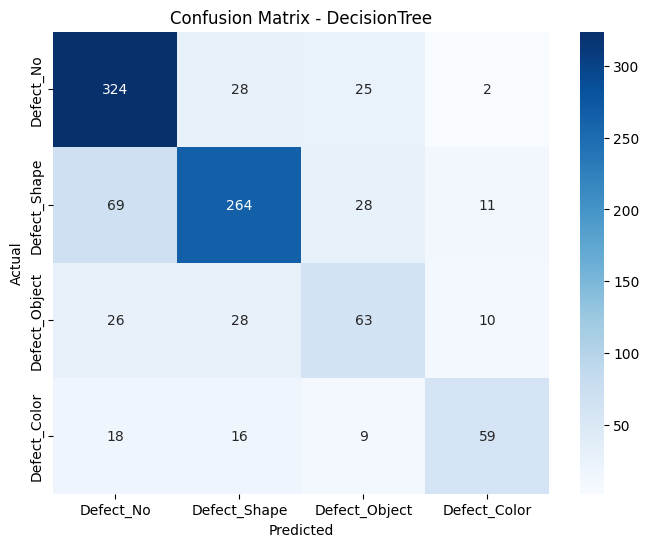

In [20]:
# DecisionTree
param_grid = {"criterion": ["gini","entropy"], "max_depth": [None,5,10,20], "ccp_alpha": [0.0,0.001,0.005]}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
t0 = time.time()
gs.fit(X_train_feat, y_train)
t1 = time.time()
y_pred = gs.best_estimator_.predict(X_test_feat)
evaluate_and_save("DecisionTree", gs.best_estimator_, X_test_feat, y_test, y_pred, gs.best_params_, t1-t0)

plot_cm("DecisionTree", y_test, y_pred, class_mapping)


===== LogisticRegression =====
Accuracy: 0.6551020408163265
F1-macro: 0.6016609653005114
Precision-macro: 0.6231234268248831
Recall-macro: 0.5871909520863896
Best params: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


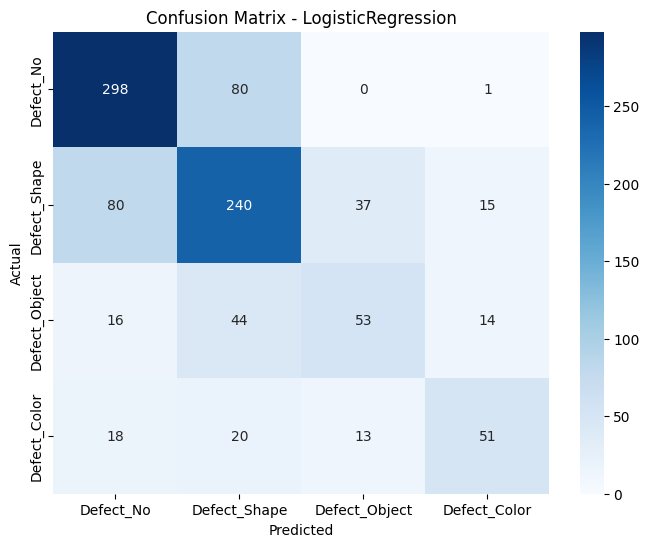

In [21]:
# LogisticRegression
param_grid = {"C":[0.1,1,10], "solver":["lbfgs"], "penalty":["l2"], "max_iter":[1000]}
gs = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
t0 = time.time()
gs.fit(X_train_feat, y_train)
t1 = time.time()
y_pred = gs.best_estimator_.predict(X_test_feat)
evaluate_and_save("LogisticRegression", gs.best_estimator_, X_test_feat, y_test, y_pred, gs.best_params_, t1-t0)

plot_cm("LogisticRegression", y_test, y_pred, class_mapping)


===== Perceptron =====
Accuracy: 0.513265306122449
F1-macro: 0.42945516786647725
Precision-macro: 0.4330297431175094
Recall-macro: 0.4275968186229404
Best params: {'alpha': 0.0001, 'max_iter': 1000, 'penalty': None}


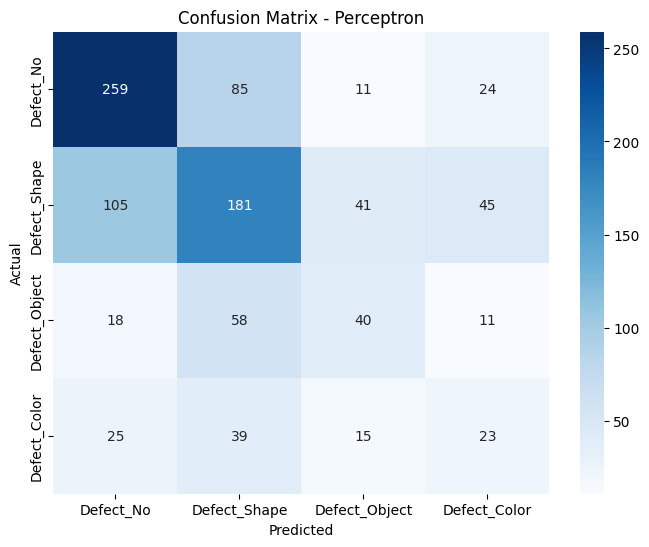

In [13]:
# Perceptron
param_grid = {"alpha":[1e-4,1e-3,1e-2], "penalty":[None,"l2"], "max_iter":[1000]}
gs = GridSearchCV(Perceptron(random_state=42), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
t0 = time.time()
gs.fit(X_train_feat, y_train)
t1 = time.time()
y_pred = gs.best_estimator_.predict(X_test_feat)
evaluate_and_save("Perceptron", gs.best_estimator_, X_test_feat, y_test, y_pred, gs.best_params_, t1-t0)

plot_cm("Perceptron", y_test, y_pred, class_mapping)

In [ ]:
# Risultati finali modelli classici
df_results = pd.DataFrame(results).sort_values("accuracy", ascending=False)
print("\n===== RISULTATI CLASSICI =====")
print(df_results.to_string(index=False))


===== RISULTATI CLASSICI =====
             model  accuracy  macro_f1  macro_precision  macro_recall                                                      best_params  fit_time_sec
               KNN  0.768367  0.673850         0.819227      0.645527                        {'metric': 'euclidean', 'n_neighbors': 3}      0.861450
      DecisionTree  0.724490  0.670296         0.687661      0.659763    {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 10}     14.140237
LogisticRegression  0.655102  0.601661         0.623123      0.587191 {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}      1.148505
        Perceptron  0.513265  0.429455         0.433030      0.427597             {'alpha': 0.0001, 'max_iter': 1000, 'penalty': None}      0.460167


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 46, 46, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 19, 19, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,676 (1018.27 KB)

 Trainable params: 260,676 (1018.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 37s 359ms/step - accuracy: 0.4509 - loss: 1.1528 - val_accuracy: 0.6888 - val_loss: 0.9143
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 31s 313ms/step - accuracy: 0.6901 - loss: 0.8160 - val_accuracy: 0.7870 - val_loss: 0.6536
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 37s 376ms/step - accuracy: 0.8045 - loss: 0.6047 - val_accuracy: 0.8457 - val_loss: 0.5100
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 65s 664ms/step - accuracy: 0.8396 - loss: 0.5299 - val_accuracy: 0.8903 - val_loss: 0.4358
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 58s 593ms/step - accuracy: 0.8724 - loss: 0.4206 - val_accuracy: 0.8941 - val_loss: 0.3064
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 52s 526ms/step - accuracy: 0.8903 - loss: 0.3787 - val_accuracy: 0.8941 - val_loss: 0.3347
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 52s 530ms/step - accuracy: 0.9104 - loss: 0.3305 - val_accuracy: 0.9005 - val_loss: 0.3085
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 64s 657ms/step - accuracy: 0.9110 - loss: 0.3088 - val_accu

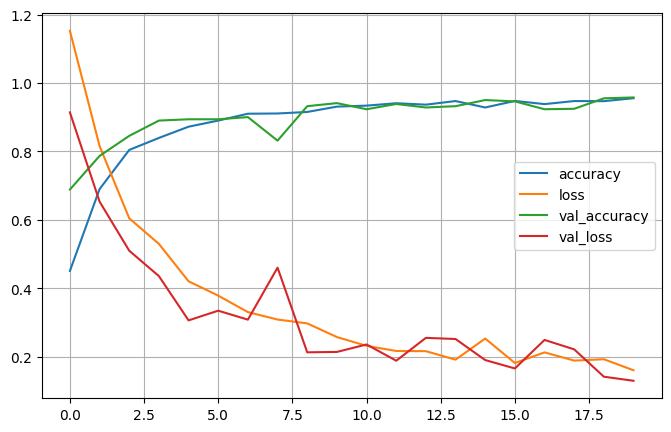

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step


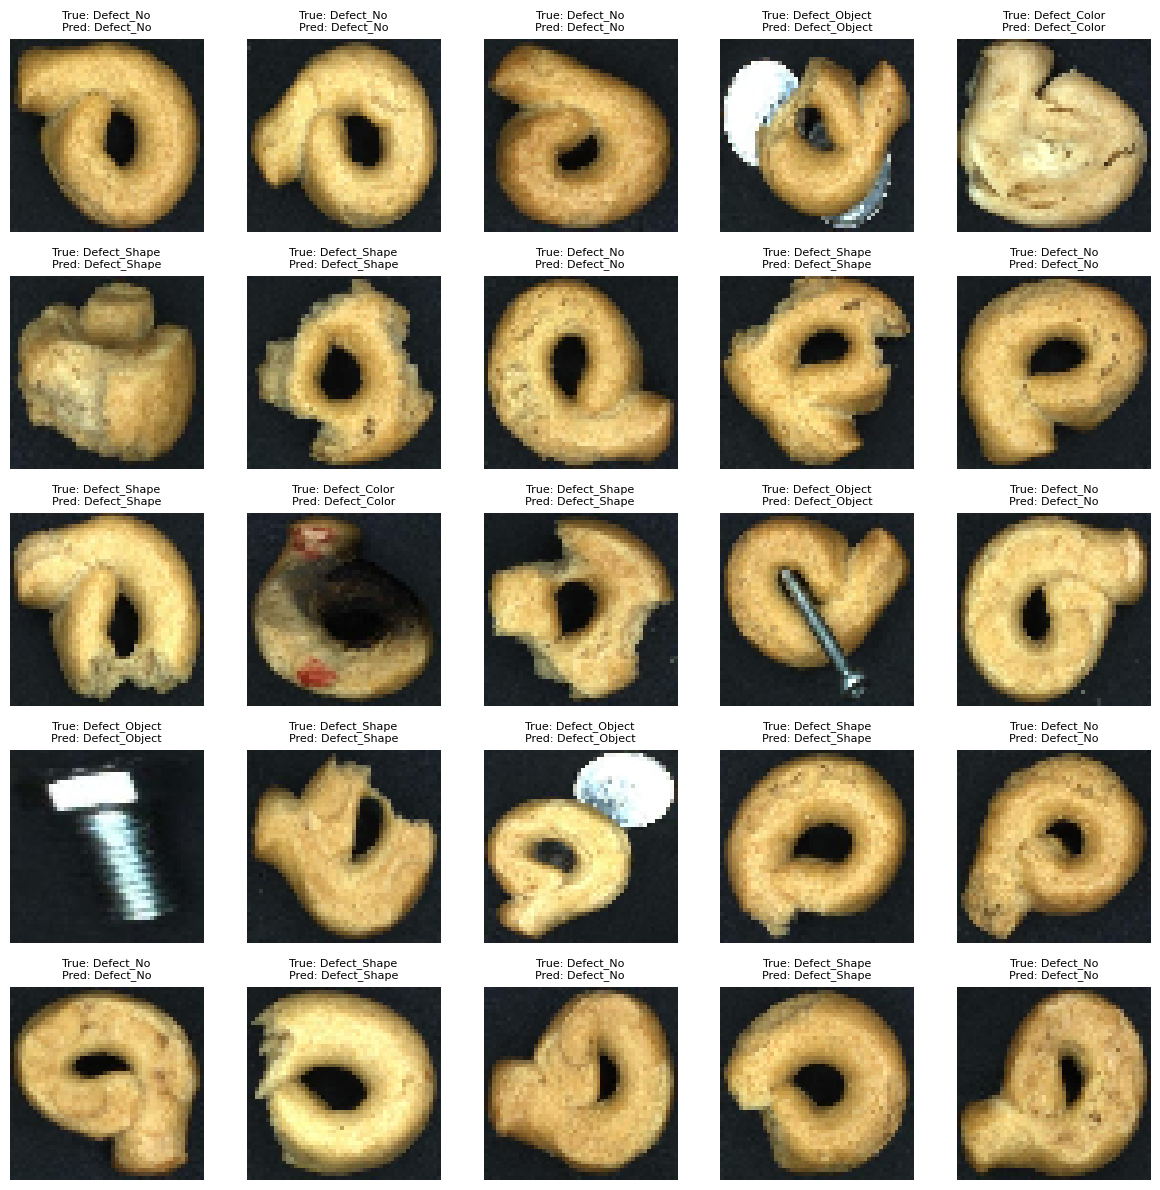

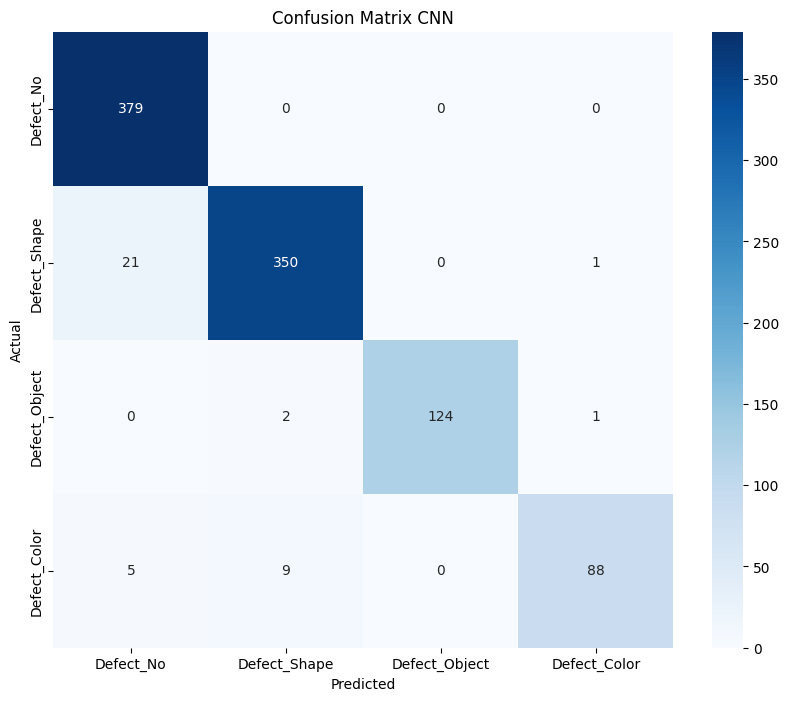

In [24]:
# ===============================================
# === BLOCCO 7 - CNN ===
# ===============================================

input_shape = (50,50,3)
model = keras.Sequential([
    keras.layers.Input(shape=input_shape),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128,(3,3),activation='relu'),
    keras.layers.Conv2D(128,(3,3),activation='relu'),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]

history = model.fit(x_train, y_train, epochs=20, validation_split=0.2, callbacks=callbacks)

# Storia training
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

# Predict
predictions = model.predict(x_test)
cpredictions = [np.argmax(p) for p in predictions]

# Griglia immagini predizioni
plt.figure(figsize=(12,12))
for i in range(1,26):
    img = x_test[-i]
    plt.subplot(5,5,i)
    plt.imshow(img)
    plt.title(f"True: {class_mapping[y_test[-i]]}\nPred: {class_mapping[cpredictions[-i]]}", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Confusion matrix CNN
label_names = [class_mapping[i] for i in range(num_classes)]
cm = confusion_matrix(y_test, cpredictions)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix CNN')
plt.show()